In [ ]:
from google.colab import drive
drive.mount("/content/driveG")

Drive already mounted at /content/driveG; to attempt to forcibly remount, call drive.mount("/content/driveG", force_remount=True).


In [ ]:
#installing the necessary libraries
!pip install torch

In [ ]:
!pip install torchinfo

In [ ]:
!pip install torchvision

In [ ]:
!pip install torchmetrics -U mlxtend # Install torchmetrics and mlxtend here


In [ ]:
#Setting up the necessary libraries
import torch
import torchvision
from torch import nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import cv2
import numpy as np
from PIL import Image
from torchinfo import summary  # For model summary
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix


# Set manual seeds for reproducibility
torch.manual_seed(42)
torch.cuda.manual_seed(42)


In [ ]:
# Define device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# Path to the dataset inside Google Drive
train_dir = '/content/driveG/MyDrive/archive (1)/data/train'
test_dir = '/content/driveG/MyDrive/archive (1)/data/test' # Corrected path

In [ ]:
# Verify that the images in the dataset is a valid image or not
import os
from PIL import Image

def remove_corrupt_images(directory):
    """
    Recursively remove corrupted image files from a directory.

    Args:
        directory (str): The path to the directory to check.
    """
    for root, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                with Image.open(file_path) as img:
                    img.verify()  # Verify that the file is a valid image
            except Exception as e:
                print(f"Corrupted file detected: {file_path}\nError: {e}")
                try:
                    os.remove(file_path)
                    print(f"Removed corrupted file: {file_path}")
                except Exception as remove_error:
                    print(f"Failed to remove file {file_path}. Error: {remove_error}")

# Run the removal on both training and testing directories:
remove_corrupt_images('/content/drive/MyDrive/archive (1)/data/train')
remove_corrupt_images('/content/drive/MyDrive/archive (1)/data/test')


In [ ]:
def create_dataloaders(train_dir, test_dir, transform, batch_size):
    """
    Creates training and testing DataLoaders.
    """
    train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
    test_dataset  = datasets.ImageFolder(root=test_dir, transform=transform)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    class_names = train_dataset.classes
    return train_dataloader, test_dataloader, class_names


In [ ]:
#Data preprocessing Pipeline
# Define BilateralFilter for noise reduction
class BilateralFilter:
    def __init__(self, diameter=5, sigma_color=50, sigma_space=50):
        self.diameter = diameter
        self.sigma_color = sigma_color
        self.sigma_space = sigma_space

    def __call__(self, img):
        img_np = np.array(img)
        # If RGB, convert to grayscale first
        if len(img_np.shape) == 3 and img_np.shape[2] == 3:
            img_np = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
        filtered = cv2.bilateralFilter(img_np, d=self.diameter,
                                       sigmaColor=self.sigma_color,
                                       sigmaSpace=self.sigma_space)
        return Image.fromarray(filtered)




In [ ]:
# Define the final transformation pipeline for CNN training.
# We convert images to 3-channel grayscale to match model's input.
data_transforms = transforms.Compose([
    BilateralFilter(diameter=5, sigma_color=50, sigma_space=50),  # Noise reduction
    transforms.RandomHorizontalFlip(p=0.5),                        # Augmentation: Flip
    transforms.RandomRotation(degrees=10),                         # Augmentation: Rotate
    transforms.Grayscale(num_output_channels=3),                   # Convert to 3-channel grayscale
    transforms.CenterCrop(200),                                    # Crop edges (adjust as needed)
    transforms.Resize((224, 224)),                                 # Resize to 224x224
    transforms.ToTensor(),                                         # Convert to tensor [0,1]
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])# Normalize to [-1,1]
])

In [ ]:
# Create DataLoaders using our transformation pipeline
train_dataloader, test_dataloader, class_names = create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=data_transforms,
    batch_size=32
)

In [ ]:
# Function to visualize a batch of transformed images
def show_transformed_batch(dataloader, class_names):
    data_iter = iter(dataloader)
    images, labels = next(data_iter)
    # Unnormalize images for display: from [-1,1] back to [0,1]
    images = images * 0.5 + 0.5
    img_grid = torchvision.utils.make_grid(images[:8], nrow=4)
    np_img = img_grid.numpy()
    plt.figure(figsize=(10, 5))
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.axis('off')
    plt.title("Sample Transformed Images")
    plt.show()
    print("Labels:", [class_names[label] for label in labels[:8]])


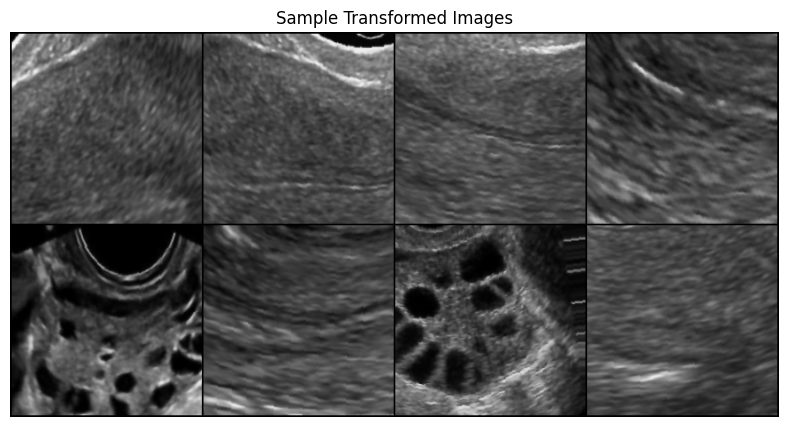

Labels: ['notinfected', 'notinfected', 'notinfected', 'notinfected', 'infected', 'notinfected', 'infected', 'notinfected']


In [ ]:
# Visualize a batch from the training dataloader
show_transformed_batch(train_dataloader, class_names)
